In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import torch 
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image


In [ ]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
epoch_num = 50
lr = 1e-3
batchsize = 32

In [ ]:
trainset = datasets.CIFAR10(root='./data', train=True, download=True,transform=transform)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=batchsize,shuffle=True)

testloader = DataLoader(testset, batch_size=batchsize, shuffle=True)

100%|██████████| 170498071/170498071 [00:07<00:00, 21373022.22it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


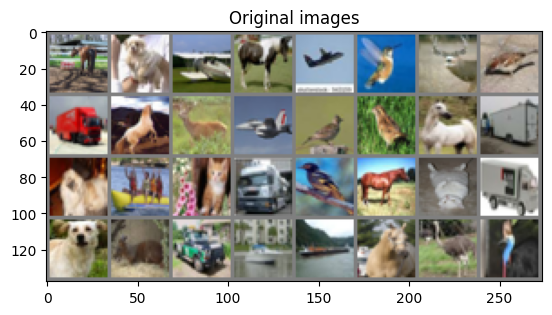

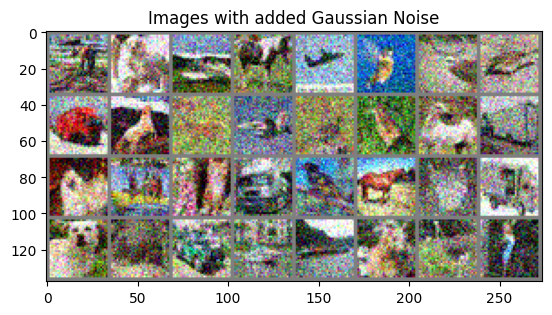

In [ ]:
import numpy as np
def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
img, _ = next(iter(trainloader))
noisy_img = img + (0.1**0.5)*torch.randn(img.shape)
noisy_img = torch.clamp(noisy_img, -1, 1)
plt.title("Original images")
imshow(torchvision.utils.make_grid(img))
plt.title("Images with added Gaussian Noise")
imshow(torchvision.utils.make_grid(noisy_img))

In [ ]:
def save_recon_image(img, name):
    img = img.view(img.size(0), 3, 32, 32)
    save_image(img, name)

def DAE_make_dir():
    image_dir = 'DenoisedAE_Conv_CIFAR10_Images'
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)


In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # encoder
        self.enc1 = nn.Conv2d(
            in_channels=3, out_channels=8, kernel_size=3,stride=1, padding=0
        )
        self.bn1 = nn.BatchNorm2d(8)
        self.enc2 = nn.Conv2d(
            in_channels=8, out_channels=8, kernel_size=3,stride=1, padding=0
        )
        self.bn2 = nn.BatchNorm2d(8)
        # decoder 
        self.dec1 = nn.ConvTranspose2d(
            in_channels=8, out_channels=8, kernel_size=3,stride=1, padding=0
        )
        self.bn3 = nn.BatchNorm2d(8)
        self.dec2 = nn.ConvTranspose2d(
            in_channels=8, out_channels=3, kernel_size=3,stride=1, padding=0
        )
    def forward(self, x):
       x = F.relu(self.bn1(self.enc1(x)))
       x = F.relu(self.bn2(self.enc2(x)))
       x = F.relu(self.bn3(self.dec1(x)))
       x = F.relu(self.dec2(x))
       return x
model = Autoencoder()
print(model)

Autoencoder(
  (enc1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dec1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dec2): ConvTranspose2d(8, 3, kernel_size=(3, 3), stride=(1, 1))
)


In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, gamma=0.1, step_size=30)


In [ ]:
from torch.types import Device
import numpy as np
def train(net, trainloader, NUM_EPOCHS):
    train_loss = []
    for epoch in range(epoch_num):
        running_loss = 0.0
        for data in trainloader:
            img, _ = data # no need for the labels
            noisy_img = img + (0.1**0.5)*torch.randn(img.shape)
            # print("Img:", img.min(), img.max())   
            noisy_img = torch.clamp(noisy_img, -1, 1)
            # print("Noisy Img:", noisy_img.min(), noisy_img.max())
            img = img.to(device)
            noisy_img = noisy_img.to(device)
            optimizer.zero_grad()
            outputs = net(noisy_img)
            # imshow(torchvision.utils.make_grid(outputs))
            loss = criterion(outputs, img)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        scheduler.step()
        loss = running_loss / len(trainloader)
        train_loss.append(loss)
        print('Epoch {} of {}, Train Loss: {}'.format(
            epoch+1, epoch_num, loss))
        if epoch % 1 == 0:
            save_recon_image(img.cpu().data, name='./DenoisedAE_Conv_CIFAR10_Images/original{}.png'.format(epoch))
            save_recon_image(outputs.cpu().data, name='./DenoisedAE_Conv_CIFAR10_Images/decoded{}.png'.format(epoch))
    return train_loss


In [ ]:
from skimage import metrics
def test(model, testloader):
     avg_psnr=0
     avg_ssim=0
     testset_size=0
     for idx, batch in enumerate(testloader):
        img, _ = batch
        noisy_img = img + (0.1**0.5)*torch.randn(img.shape)
        noisy_img = torch.clamp(noisy_img, -1, 1)
        img = img.to(device)
        noisy_img = noisy_img.to(device)
        outputs = model(noisy_img)
        batch_avg_psnr=0
        batch_avg_ssim=0
        for i in range(len(img)):
            original=np.transpose(img[i].detach().cpu(), (1, 2, 0)).numpy()
            denoised=np.transpose(outputs[i].detach().cpu(), (1, 2, 0)).numpy()
            batch_avg_psnr+=metrics.peak_signal_noise_ratio(original,denoised)
            batch_avg_ssim+=metrics.structural_similarity(original,denoised,multichannel=True)
        avg_psnr+=batch_avg_psnr
        avg_ssim+=batch_avg_ssim
        testset_size+=len(img)
        outputs = outputs.view(outputs.size(0), 3, 32, 32).cpu().data

        if idx==1:
          save_image(img,'DAE_original_image.png')
          save_image(noisy_img,'DAE_noisy_image.png')
          save_image(outputs, 'DAE_conv_cifar10_reconstruction.png')
     print("On Test data of {} examples:\nAverage PSNR:{:.3f} \nAverage SSIM: {:.3f}".format(testset_size,avg_psnr/testset_size,avg_ssim/testset_size))
     

cpu
Epoch 1 of 50, Train Loss: 0.1612360575930552
Epoch 2 of 50, Train Loss: 0.15198724470455832
Epoch 3 of 50, Train Loss: 0.1512828861921549
Epoch 4 of 50, Train Loss: 0.15076204467986687
Epoch 5 of 50, Train Loss: 0.15038704803488762
Epoch 6 of 50, Train Loss: 0.15028236346868698
Epoch 7 of 50, Train Loss: 0.1502493253443688
Epoch 8 of 50, Train Loss: 0.15013146675498684
Epoch 9 of 50, Train Loss: 0.14996734695772446
Epoch 10 of 50, Train Loss: 0.14986404004344098
Epoch 11 of 50, Train Loss: 0.14978471400260315
Epoch 12 of 50, Train Loss: 0.14977318712022164
Epoch 13 of 50, Train Loss: 0.14975653221247978
Epoch 14 of 50, Train Loss: 0.14970787923952286
Epoch 15 of 50, Train Loss: 0.14971123827396107
Epoch 16 of 50, Train Loss: 0.14956135934865863
Epoch 17 of 50, Train Loss: 0.14961730179711175
Epoch 18 of 50, Train Loss: 0.1494965816508938
Epoch 19 of 50, Train Loss: 0.1494811296949231
Epoch 20 of 50, Train Loss: 0.1495516972946419
Epoch 21 of 50, Train Loss: 0.1495902527717162
Epoc

<ipython-input-14-736b6060f955>:19: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  batch_avg_ssim+=metrics.structural_similarity(original,denoised,multichannel=True)
<ipython-input-14-736b6060f955>:19: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  batch_avg_ssim+=metrics.structural_similarity(original,denoised,multichannel=True)
<ipython-input-14-736b6060f955>:19: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  batch_avg_ssim+=metrics.structural_similarity(original,denoised,multichannel=True)
<ipython-input-14-736b6060f955>:19: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. 

On Test data of 10000 examples:
Average PSNR:15.443 
Average SSIM: 0.214


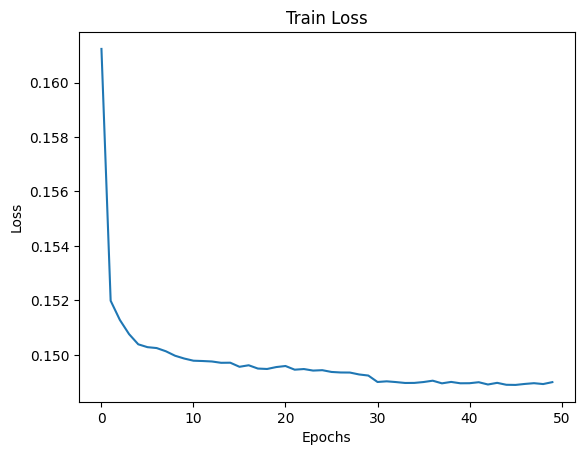

In [ ]:
# net = Autoencoder()
device = get_device()
print(device)
model.to(device)
DAE_make_dir()
train_loss = train(model, trainloader, epoch_num)
plt.figure()
plt.plot(train_loss)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('DAE_conv_ae_cifar10_loss.png')
test(model, testloader)